<a href="https://colab.research.google.com/github/9githubisuru/CEBEVProject-Backend_Postgres_V4/blob/main/Test_Pumpkin_Leaf_Model_after_Retrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive (run this cell)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# Path to the existing model .h5 you received
MODEL_PATH = '/content/drive/MyDrive/Research/Pumpkin_classification_research/pumpkin_disease_model.h5'
# Path to dataset root. Either:
# - dataset/ has subfolders: train/, val/, test/  (each contains class subfolders)
# - or dataset/ itself contains class subfolders (then the code will split train/val automatically)
DATA_DIR = '/content/drive/MyDrive/Research/Mendeley Dataset/Augmented Images'
# Where to save outputs (models, plots, reports)
OUTPUT_DIR = '/content/drive/MyDrive/Research/Mendeley Dataset/Model'
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [ ]:
BATCH_SIZE = 32
EPOCHS = 20
SEED = 123
AUTOTUNE = None  # will be set after importing TF

In [ ]:
 import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import json

AUTOTUNE = tf.data.AUTOTUNE

print('TensorFlow version:', tf.__version__)

# %%
# 1) Load existing model and inspect input/output shapes
print('\nLoading model from:', MODEL_PATH)
try:
    model = load_model(MODEL_PATH)
except Exception as e:
    print('Error loading model:', e)
    raise

model.summary()

inp = model.input_shape
if isinstance(inp, list):
    # sometimes model has multiple inputs — take first
    inp = inp[0]
if len(inp) == 4:
    _, H, W, C = inp
elif len(inp) == 3:
    H, W, C = inp
else:
    raise ValueError(f'Unexpected model.input_shape: {model.input_shape}')
IMAGE_SIZE = (int(H), int(W))
print('Inferred IMAGE_SIZE =', IMAGE_SIZE, 'channels =', C)


TensorFlow version: 2.19.0

Loading model from: /content/drive/MyDrive/Research/Pumpkin_classification_research/pumpkin_disease_model.h5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,169,351 (27.35 MB)

 Trainable params: 7,085,701 (27.03 MB)

 Non-trainable params: 83,648 (326.75 KB)

 Optimizer params: 2 (12.00 B)

Inferred IMAGE_SIZE = (224, 224) channels = 3


In [ ]:
train_dir = None
val_dir = None
test_dir = None

if os.path.isdir(os.path.join(DATA_DIR, 'train')):
    train_dir = os.path.join(DATA_DIR, 'train')
    if os.path.isdir(os.path.join(DATA_DIR, 'val')):
        val_dir = os.path.join(DATA_DIR, 'val')
    if os.path.isdir(os.path.join(DATA_DIR, 'test')):
        test_dir = os.path.join(DATA_DIR, 'test')
else:
    # assume DATA_DIR contains class subfolders
    train_dir = DATA_DIR

print('train_dir =', train_dir)
print('val_dir =', val_dir)
print('test_dir =', test_dir)

# Create tf.data datasets
if val_dir is None and (train_dir is not None and os.path.isdir(train_dir) and os.path.isdir(train_dir)):
    # use validation_split on train_dir
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='int',
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        validation_split=0.3,
        subset='training',
        seed=SEED,
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='int',
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        validation_split=0.3,
        subset='validation',
        seed=SEED,
    )
else:
    # train_dir with separate val_dir or explicit train/val/test folders
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='int',
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
    )
    val_ds = None
    if val_dir is not None:
        val_ds = tf.keras.utils.image_dataset_from_directory(
            val_dir,
            labels='inferred',
            label_mode='int',
            image_size=IMAGE_SIZE,
            batch_size=BATCH_SIZE,
            shuffle=False,
        )

if test_dir is not None:
    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        labels='inferred',
        label_mode='int',
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )
else:
    test_ds = None

# Save class names
class_names = train_ds.class_names
print('Class names:', class_names)

train_dir = /content/drive/MyDrive/Research/Mendeley Dataset/Augmented Images
val_dir = None
test_dir = None
Found 2589 files belonging to 4 classes.
Using 1813 files for training.
Found 2589 files belonging to 4 classes.
Using 776 files for validation.
Class names: ['Bacterial Leaf Disease', 'Dried Leaf', 'Fungal Brown Spot Disease', 'Healthy Leaf']


In [ ]:
def count_files_by_class(folder):
    classes = [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]
    classes = sorted(classes)
    counts = {}
    for c in classes:
        cpath = os.path.join(folder, c)
        files = [f for f in os.listdir(cpath) if f.lower().endswith(('.jpg','.jpeg','.png','.bmp'))]
        counts[c] = len(files)
    return counts

if os.path.isdir(train_dir):
    try:
        counts = count_files_by_class(train_dir)
        print('File counts per class (from folders):', counts)
        counts_list = [counts.get(c, 0) for c in class_names]
    except Exception as e:
        print('Could not count files from folders:', e)
        counts_list = None
else:
    counts_list = None

if counts_list is None:
    # fallback: read from train_ds
    labels = []
    for _, y in train_ds.unbatch():
        labels.append(int(y.numpy()))
    labels = np.array(labels)
    classes, counts_vals = np.unique(labels, return_counts=True)
    counts_list = [int(counts_vals[list(classes).index(i)]) if i in classes else 0 for i in range(len(class_names))]

print('counts_list:', counts_list)

# Balanced class weights: inverse proportional to frequency
from math import ceil
max_count = max(counts_list)
class_weights = {i: float(max_count / c) if c > 0 else 1.0 for i, c in enumerate(counts_list)}
print('class_weights:', class_weights)


File counts per class (from folders): {'Bacterial Leaf Disease': 656, 'Dried Leaf': 648, 'Fungal Brown Spot Disease': 642, 'Healthy Leaf': 643}
counts_list: [656, 648, 642, 643]
class_weights: {0: 1.0, 1: 1.0123456790123457, 2: 1.0218068535825544, 3: 1.0202177293934682}


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1.0/255)

data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.12),
    layers.RandomContrast(0.08),
])

# Apply normalization and augmentation to train dataset only
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
# train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(AUTOTUNE)

if val_ds is not None:
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
if test_ds is not None:
    test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

In [ ]:
FREEZE = False
NUM_LAYERS_TO_UNFREEZE_AT_END = 10  # only used if FREEZE=True

if FREEZE:
    # Freeze all, then unfreeze last N layers
    for layer in model.layers:
        layer.trainable = False
    for layer in model.layers[-NUM_LAYERS_TO_UNFREEZE_AT_END:]:
        layer.trainable = True
    print('Freezing all layers except last', NUM_LAYERS_TO_UNFREEZE_AT_END)
else:
    # default: leave model trainable
    for layer in model.layers:
        layer.trainable = True

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Callbacks
callbacks = []
checkpoint_path = os.path.join(OUTPUT_DIR, 'best_model.h5')
callbacks.append(keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, save_weights_only=False))
callbacks.append(keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True))
callbacks.append(keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7))

In [ ]:
# 7) Train
if val_ds is None:
    print('No validation dataset found, training with validation_split is recommended. Running training against available datasets.')

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7257 - loss: 0.8252

57/57 ━━━━━━━━━━━━━━━━━━━━ 611s 8s/step - accuracy: 0.7280 - loss: 0.8181 - val_accuracy: 0.9845 - val_loss: 0.0711 - learning_rate: 1.0000e-04
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.9923 - loss: 0.0351

57/57 ━━━━━━━━━━━━━━━━━━━━ 25s 445ms/step - accuracy: 0.9923 - loss: 0.0351 - val_accuracy: 0.9961 - val_loss: 0.0215 - learning_rate: 1.0000e-04
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 376ms/step - accuracy: 0.9990 - loss: 0.0118 - val_accuracy: 0.9961 - val_loss: 0.0124 - learning_rate: 1.0000e-04
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 346ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 0.9948 - val_loss: 0.0104 - learning_rate: 1.0000e-04
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 350ms/step - accuracy: 0.9997 - loss: 0.0041 - val_accuracy: 0.9923 - val_loss: 0.0258 - learning_rate: 1.0000e-04
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 343ms/step - accuracy: 0.9999 - loss: 0.0030 - val_accuracy: 0.9948 - val_loss: 0.0153 - learning_rate: 1.0000e-04
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 353ms/step - accuracy: 0.9987 - loss: 0.0044 - val_accuracy: 0.9948 - val_loss: 0.0225 - learning_rate: 1.0000e-04
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 345ms/step - accuracy: 0.99

Saved finetuned model to /content/drive/MyDrive/Research/Mendeley Dataset/Model/model_finetuned.h5


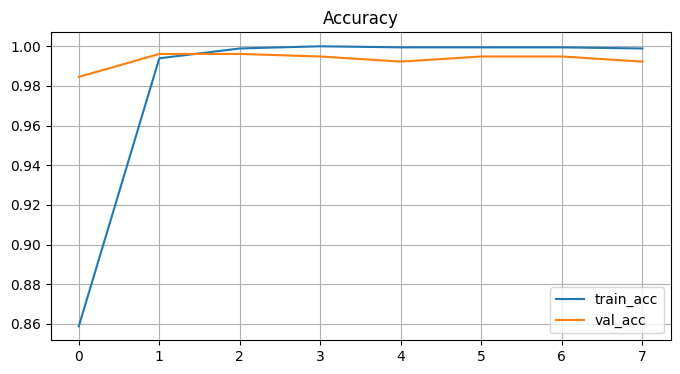

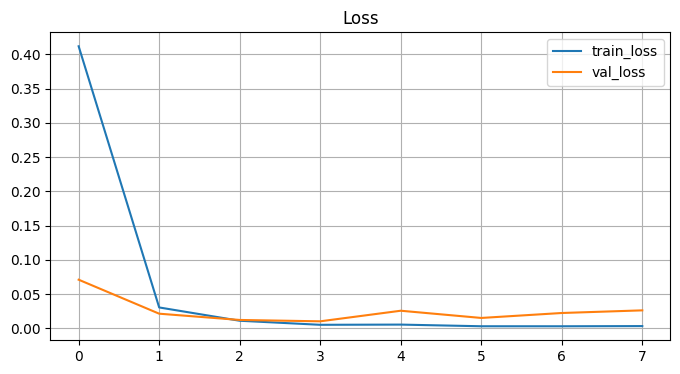

In [ ]:
# Save final model
final_path = os.path.join(OUTPUT_DIR, 'model_finetuned.h5')
model.save(final_path)
print('Saved finetuned model to', final_path)

# %%
# 8) Plot training history
plt.figure(figsize=(8,4))
plt.plot(history.history.get('accuracy', []), label='train_acc')
plt.plot(history.history.get('val_accuracy', []), label='val_acc')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.history.get('loss', []), label='train_loss')
plt.plot(history.history.get('val_loss', []), label='val_loss')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 9) Evaluate on test set (if available) and show classification report
if test_ds is None:
    print('No test dataset provided. Evaluate on validation dataset instead.')
    eval_ds = val_ds
else:
    eval_ds = test_ds

if eval_ds is not None:
    # gather true labels
    y_true = []
    for _, y in eval_ds:
      y_true.extend(y.numpy())
    y_true = np.array(y_true)

    y_prob = model.predict(eval_ds)
    y_pred = np.argmax(y_prob, axis=1)

    # Get class names from the evaluation dataset
    # Access class names from the original dataset object (train_ds)
    eval_class_names = class_names
    print('Class names:', eval_class_names) # print class names from the original dataset object
    print('\nClassification report:')
    # Explicitly specify the labels parameter to include all possible class indices
    print(classification_report(y_true, y_pred, target_names=eval_class_names, labels=np.arange(len(eval_class_names))))

    print('\nConfusion matrix:')
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(eval_class_names)))
    print(cm)

    # Save report
    report_path = os.path.join(OUTPUT_DIR, 'classification_report.json')
    # Convert the report to a dictionary before saving as JSON
    report_dict = classification_report(y_true, y_pred, target_names=eval_class_names, output_dict=True, labels=np.arange(len(eval_class_names)))
    with open(report_path, 'w') as f:
        json.dump(report_dict, f, indent=4)
    np.savetxt(os.path.join(OUTPUT_DIR,'confusion_matrix.txt'), cm, fmt='%d')
    print('Saved classification report and confusion matrix to', OUTPUT_DIR)
else:
    print('No evaluation dataset found; skip evaluation.')

No test dataset provided. Evaluate on validation dataset instead.


25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 622ms/step
Class names: ['Bacterial Leaf Disease', 'Dried Leaf', 'Fungal Brown Spot Disease', 'Healthy Leaf']

Classification report:
                           precision    recall  f1-score   support

   Bacterial Leaf Disease       0.00      0.00      0.00         0
               Dried Leaf       0.00      0.00      0.00         0
Fungal Brown Spot Disease       0.04      0.15      0.06       133
             Healthy Leaf       0.78      0.07      0.13       643

                micro avg       0.09      0.09      0.09       776
                macro avg       0.21      0.06      0.05       776
             weighted avg       0.66      0.09      0.12       776


Confusion matrix:
[[  0   0   0   0]
 [  0   0   0   0]
 [ 28  72  20  13]
 [ 26  72 477  47]]
Saved classification report and confusion matrix to /content/drive/MyDrive/Research/Mendeley Dataset/Model


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p

Saved finetuned model to /content/drive/MyDrive/Research/Mendeley Dataset/Model/model_finetuned.h5


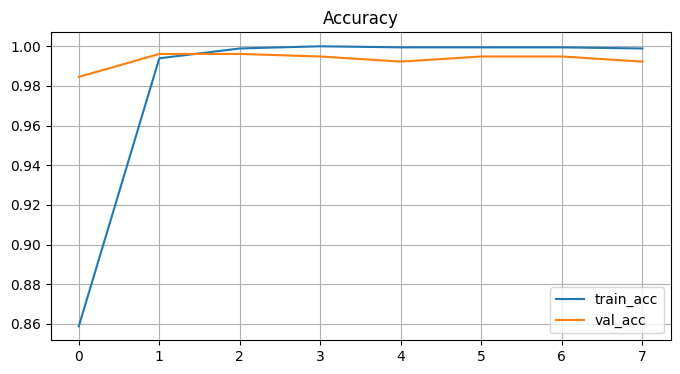

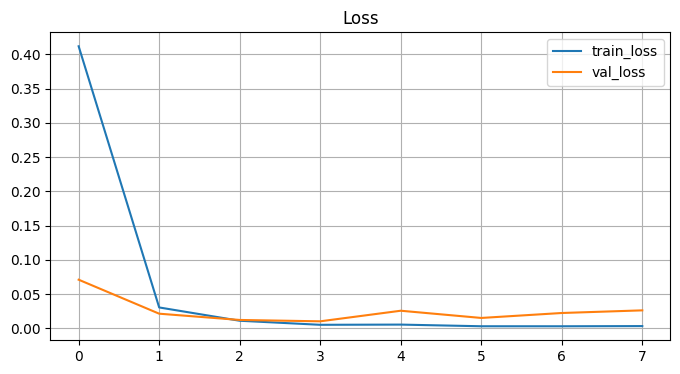

In [ ]:
# Save final model
final_path = os.path.join(OUTPUT_DIR, 'model_finetuned.h5')
model.save(final_path)
print('Saved finetuned model to', final_path)

# %%
# 8) Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(history.history.get('accuracy', []), label='train_acc')
plt.plot(history.history.get('val_accuracy', []), label='val_acc')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.history.get('loss', []), label='train_loss')
plt.plot(history.history.get('val_loss', []), label='val_loss')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 10) Quick predict helper - use to test single images
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

def predict_image(img_path, model, class_names, image_size=IMAGE_SIZE):
    img = load_img(img_path, target_size=image_size)
    arr = img_to_array(img)
    arr = arr.astype('float32') / 255.0
    arr = np.expand_dims(arr, axis=0)
    preds = model.predict(arr)
    idx = int(np.argmax(preds, axis=1)[0])
    return class_names[idx], float(np.max(preds))

In [ ]:
# Example: set a path and test
test_image = '/content/drive/MyDrive/Research/Mendeley Dataset/Original Images/Fungal Brown Spot Disease/Fungal_Brown_Spot_Disease(1).jpg' # Replace with a path to your test image
print(predict_image(test_image, model, class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
('Fungal Brown Spot Disease', 0.9885973334312439)


In [ ]:
from tensorflow.keras.models import load_model

# Load your model
model_path = "/content/drive/MyDrive/Research/Mendeley Dataset/Model/model_finetuned.h5"  # change if needed
model = load_model(model_path)

# 1️⃣ Summary of layers
model.summary()

# 2️⃣ Detailed layer info (optional)
for i, layer in enumerate(model.layers):
    print(f"\nLayer {i+1}: {layer.name}")
    print(f"Type: {layer.__class__.__name__}")
    if hasattr(layer, 'output_shape'):
        print(f"Output shape: {layer.output_shape}")
    elif hasattr(layer, 'batch_input_shape'):
        print(f"Input shape: {layer.batch_input_shape}")

    print(f"Number of parameters: {layer.count_params()}")
    print(f"Trainable: {layer.trainable}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,169,351 (27.35 MB)

 Trainable params: 7,085,701 (27.03 MB)

 Non-trainable params: 83,648 (326.75 KB)

 Optimizer params: 2 (12.00 B)


Layer 1: input_layer
Type: InputLayer
Number of parameters: 0
Trainable: True

Layer 2: zero_padding2d
Type: ZeroPadding2D
Number of parameters: 0
Trainable: True

Layer 3: conv1_conv
Type: Conv2D
Number of parameters: 9408
Trainable: True

Layer 4: conv1_bn
Type: BatchNormalization
Number of parameters: 256
Trainable: True

Layer 5: conv1_relu
Type: Activation
Number of parameters: 0
Trainable: True

Layer 6: zero_padding2d_1
Type: ZeroPadding2D
Number of parameters: 0
Trainable: True

Layer 7: pool1
Type: MaxPooling2D
Number of parameters: 0
Trainable: True

Layer 8: conv2_block1_0_bn
Type: BatchNormalization
Number of parameters: 256
Trainable: True

Layer 9: conv2_block1_0_relu
Type: Activation
Number of parameters: 0
Trainable: True

Layer 10: conv2_block1_1_conv
Type: Conv2D
Number of parameters: 8192
Trainable: True

Layer 11: conv2_block1_1_bn
Type: BatchNormalization
Number of parameters: 512
Trainable: True

Layer 12: conv2_block1_1_relu
Type: Activation
Number of parameters

In [ ]:
# 10) Quick predict helper - use to test single images
from tensorflow.keras.utils import load_img, img_to_array

def predict_image(img_path, model, class_names, image_size=IMAGE_SIZE):
    img = load_img(img_path, target_size=image_size)
    arr = img_to_array(img)
    arr = arr.astype('float32') / 255.0
    arr = np.expand_dims(arr, axis=0)
    preds = model.predict(arr)
    idx = int(np.argmax(preds, axis=1)[0])
    return class_names[idx], float(np.max(preds))

In [ ]:

# Example: set a path and test
test_image = '/content/drive/MyDrive/Research/Mendeley Dataset/Augmented Images/Bacterial Leaf Disease/Bacterial_Leaf_Spot_Disease-1-_jpg.rf.0f57aad42a8a1da8d916d82813dab61d.jpg'
print(predict_image(test_image, model, class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
('Bacterial Leaf Disease', 0.9900141954421997)


In [ ]:
from tensorflow.keras.models import load_model

# Load your model
model_path = "/content/drive/MyDrive/Research/Pumpkin_classification_research/pumpkin_disease_model.h5"  # change if needed
model = load_model(model_path)

# 1️⃣ Summary of layers
model.summary()

# 2️⃣ Detailed layer info (optional)
for i, layer in enumerate(model.layers):
    print(f"\nLayer {i+1}: {layer.name}")
    print(f"Type: {layer.__class__.__name__}")
    if hasattr(layer, 'output_shape'):
        print(f"Output shape: {layer.output_shape}")
    elif hasattr(layer, 'batch_input_shape'):
        print(f"Input shape: {layer.batch_input_shape}")

    print(f"Number of parameters: {layer.count_params()}")
    print(f"Trainable: {layer.trainable}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,169,351 (27.35 MB)

 Trainable params: 7,085,701 (27.03 MB)

 Non-trainable params: 83,648 (326.75 KB)

 Optimizer params: 2 (12.00 B)


Layer 1: input_layer
Type: InputLayer
Number of parameters: 0
Trainable: True

Layer 2: zero_padding2d
Type: ZeroPadding2D
Number of parameters: 0
Trainable: True

Layer 3: conv1_conv
Type: Conv2D
Number of parameters: 9408
Trainable: True

Layer 4: conv1_bn
Type: BatchNormalization
Number of parameters: 256
Trainable: True

Layer 5: conv1_relu
Type: Activation
Number of parameters: 0
Trainable: True

Layer 6: zero_padding2d_1
Type: ZeroPadding2D
Number of parameters: 0
Trainable: True

Layer 7: pool1
Type: MaxPooling2D
Number of parameters: 0
Trainable: True

Layer 8: conv2_block1_0_bn
Type: BatchNormalization
Number of parameters: 256
Trainable: True

Layer 9: conv2_block1_0_relu
Type: Activation
Number of parameters: 0
Trainable: True

Layer 10: conv2_block1_1_conv
Type: Conv2D
Number of parameters: 8192
Trainable: True

Layer 11: conv2_block1_1_bn
Type: BatchNormalization
Number of parameters: 512
Trainable: True

Layer 12: conv2_block1_1_relu
Type: Activation
Number of parameters

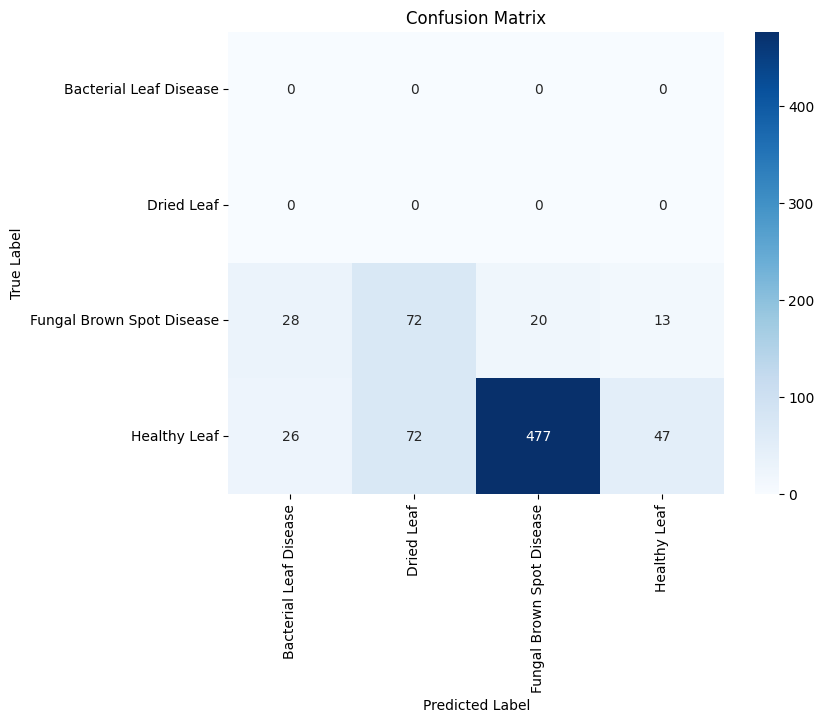

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming `cm`, `eval_class_names` are available from previous execution
# If not, ensure they are defined or uncomment the following lines to recompute if needed:
# y_pred = np.argmax(model.predict(eval_ds), axis=1)
# cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=eval_class_names, yticklabels=eval_class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Creating a full evaluation dataset from DATA_DIR without splitting...
Found 2589 files belonging to 4 classes.
Evaluating on full dataset for a complete confusion matrix.
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 317ms/step
Class names: ['Bacterial Leaf Disease', 'Dried Leaf', 'Fungal Brown Spot Disease', 'Healthy Leaf']

Classification report (Full Dataset):
                           precision    recall  f1-score   support

   Bacterial Leaf Disease       0.31      0.09      0.14       656
               Dried Leaf       0.07      0.07      0.07       648
Fungal Brown Spot Disease       0.12      0.25      0.16       642
             Healthy Leaf       0.12      0.07      0.09       643

                micro avg       0.12      0.12      0.12      2589
                macro avg       0.16      0.12      0.12      2589
             weighted avg       0.16      0.12      0.12      2589


Confusion matrix (Full Dataset):
[[ 57 196 161 219]
 [ 12  46 533  52]
 [ 87 323 159  69]
 [ 26  72 477  47]]

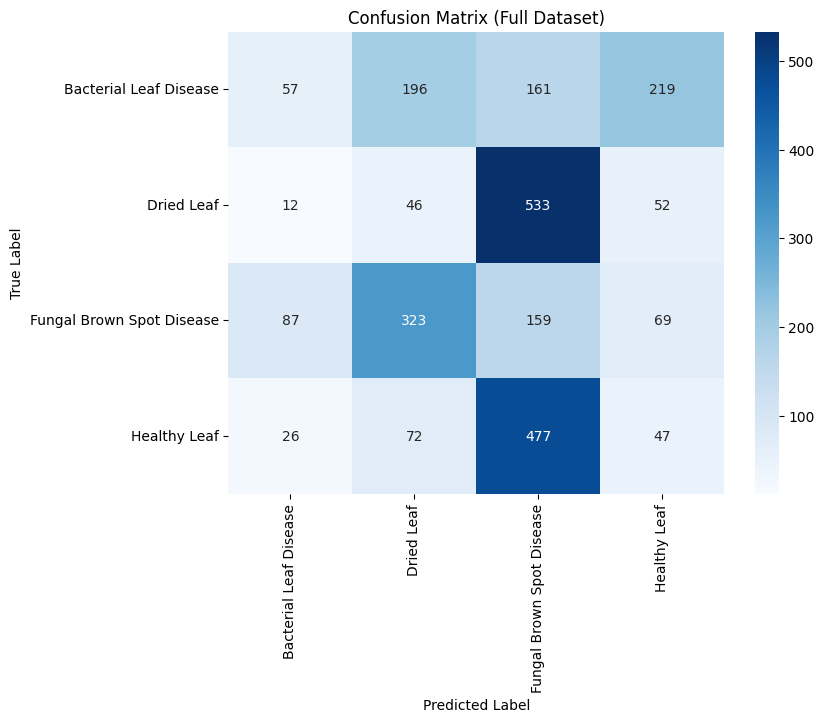

Saved full classification report and confusion matrix to /content/drive/MyDrive/Research/Mendeley Dataset/Model


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt

print('Creating a full evaluation dataset from DATA_DIR without splitting...')
# Create a full evaluation dataset from DATA_DIR without splitting
# This dataset should contain all classes if DATA_DIR has them
full_eval_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, # Use the root data directory
    labels='inferred',
    label_mode='int',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False # Do not shuffle for consistent evaluation
)

# Apply normalization to the full evaluation dataset, similar to how it was applied to train/val
normalization_layer = tf.keras.layers.Rescaling(1.0/255)
full_eval_ds = full_eval_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

print('Evaluating on full dataset for a complete confusion matrix.')

# Gather true labels
y_true_full = []
for _, y in full_eval_ds:
  y_true_full.extend(y.numpy())
y_true_full = np.array(y_true_full)

# Predict probabilities and get predicted labels
y_prob_full = model.predict(full_eval_ds)
y_pred_full = np.argmax(y_prob_full, axis=1)

# Print and plot results
print('Class names:', class_names)
print('\nClassification report (Full Dataset):')
report_dict_full = classification_report(y_true_full, y_pred_full, target_names=class_names, output_dict=True, labels=np.arange(len(class_names)))
print(classification_report(y_true_full, y_pred_full, target_names=class_names, labels=np.arange(len(class_names))))

print('\nConfusion matrix (Full Dataset):')
cm_full = confusion_matrix(y_true_full, y_pred_full, labels=np.arange(len(class_names)))
print(cm_full)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_full, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Full Dataset)')
plt.show()

# Save report and confusion matrix to files
report_path_full = os.path.join(OUTPUT_DIR, 'classification_report_full_dataset.json')
with open(report_path_full, 'w') as f:
    json.dump(report_dict_full, f, indent=4)
np.savetxt(os.path.join(OUTPUT_DIR,'confusion_matrix_full_dataset.txt'), cm_full, fmt='%d')
print('Saved full classification report and confusion matrix to', OUTPUT_DIR)